In [29]:
import fastgps 
import torch
from qmcpy import DigitalNetB2
import numpy as np
from scipy import special
from matplotlib import pyplot

In [30]:
torch.set_default_dtype(torch.float64)

In [35]:
import scipy.stats 
grid = np.linspace(0,1,27)[1:-1]
# grid0 = scipy.stats.beta.ppf(grid,a=1,b=2)
# grid1 = scipy.stats.beta.ppf(grid,a=2,b=2)
grid0 = grid
grid1 = grid
x0_data_mesh,x1_data_mesh = np.meshgrid(grid0,grid1) 
x_data = np.vstack([x0_data_mesh.flatten(),x1_data_mesh.flatten()]).T
print(x_data.shape) 

(625, 2)


In [36]:
f = lambda x: np.sin(2*np.pi*x[:,0])*np.cos(2*np.pi*x[:,1])
# f = lambda x: np.sin(2*np.pi*x[:,0])+np.sin(2*np.pi*x[:,1])+np.sin(2*np.pi*x[:,0]*x[:,1])
y_data = f(x_data)
y_data.shape

(625,)

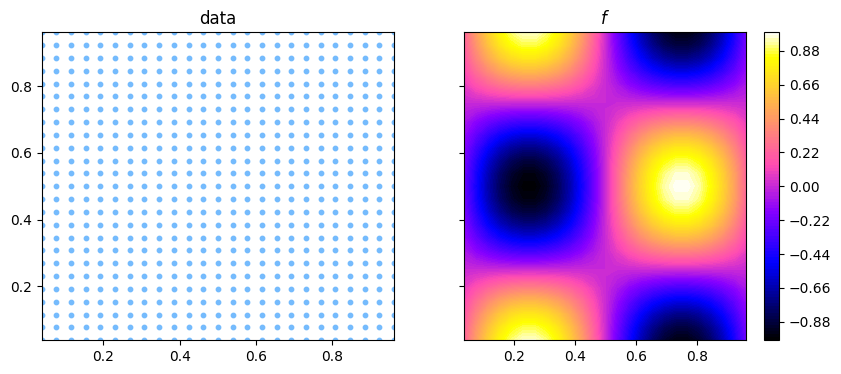

In [37]:
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(10,4),sharex=True,sharey=True)
_s = 10 
ax[0].set_title("data")
ax[0].scatter(x_data[:,0],x_data[:,1],color="xkcd:sky blue",s=_s)
ax[1].set_title(r"$f$")
_cf = ax[1].contourf(x0_data_mesh,x1_data_mesh,y_data.reshape(x0_data_mesh.shape),cmap="gnuplot2",levels=100)
fig.colorbar(_cf);

In [38]:
def logchoose(N, k):
    return special.gammaln(N+1)-special.gammaln(N-k+1)-special.gammaln(k+1)
def get_common_digits(x, z, t):
    assert x.dtype in [np.int64,np.uint64] and z.dtype in [np.int64,np.uint64]
    delta = x^z
    delta_gt_0 = delta>0
    log2delta = -np.ones(delta.shape)
    log2delta[delta_gt_0] = np.log2(delta[delta_gt_0])
    i_rev = np.floor(log2delta).astype(int)
    i = t-1-i_rev 
    return i
def compute_Nri(i_r, r, d):
    rvec = np.arange(r+1,dtype=int)
    Nrpi = (rvec<=i_r[...,0,None]).astype(int)
    for j in range(1,d):
        for rp in range(0,r+1):
            w = np.maximum(rp-i_r[...,j],0)
            mask = (rvec>=w[...,None])*(rvec<=rp)
            Nrpi[...,rp] = (Nrpi*mask).sum(-1)
    return Nrpi[...,-1]
def get_weights(z, t, x, y, nu):
    assert isinstance(t,int)
    assert z.ndim==2 and z.dtype in [np.uint64,np.int64]
    n,d = z.shape
    assert n&(n-1)==0, "require n is a power of 2"
    m = int(np.log2(n))
    assert x.ndim==2 and (0<=x).all() and (x<=1).all() and x.shape[-1]==d
    N = x.shape[0]
    x = (x*2**t).round().astype(z.dtype)
    assert y.ndim>=1 and y.shape[-1]==N
    batch_shape = list(y[...,0].shape)
    Wx = np.zeros(n)
    Wy = np.zeros(batch_shape+[n])
    i = get_common_digits(z[:,None,:],x[None,:,:],t)
    for q in range(min(d,nu+1)):
        r = nu-q
        assert r>=0 and q<=(d-1), "nu = %d, q = %d, r = %d, d = %d"%(nu,q,r,d)
        if r==0:
            Sr = N
            Tr = y.sum(-1,keepdims=True)
        else:
            i_r = np.minimum(r,i)
            Nri = compute_Nri(i_r,r,d)
            Sr = Nri.sum(-1)
            Tr = (y[...,None,:]*Nri).sum(-1)
        _c = (-1)**(-q)*np.exp(logchoose(d-1,q)+(nu-m-q)*np.log(2)-np.log(N))
        Wx = Wx+_c*Sr
        Wy = Wy+_c*Tr
    zfloat = 2**(-t)*z
    assert 0<=zfloat.min()<1/2 and 1/2<=zfloat.max()<1
    return zfloat,Wx,Wy

In [59]:
fgp = fastgps.FastGPDigitalNetB2(seqs = DigitalNetB2(2,randomize="LMS_DS",seed=7))
zb_next = fgp.get_x_next(2**11,binary=True)
print("zb_next.shape = %s"%str(zb_next.shape))
print("zb_next.dtype = %s"%(zb_next.dtype))
z,Wx,Wy = get_weights(
    z = zb_next.numpy(),
    t = fgp.t,
    x = x_data,
    y = y_data,
    nu = 10)
print("z.shape = %s"%str(z.shape))
print("Wx.shape = %s"%str(Wx.shape))
print("Wy.shape = %s"%str(Wy.shape))
fgp.add_y_next(torch.from_numpy(Wy/Wx))
data = fgp.fit(iterations=250,stop_crit_wait_iterations=250,verbose=25)
y_net = f(z)
rmse_net = np.sqrt(np.mean((y_net-Wy/Wx)**2))
l2rerror_net = np.linalg.norm(y_net-Wy/Wx)/np.linalg.norm(y_net)
print("RMSE net W_Y/W_X: %.1e"%rmse_net)
print("L2 relative error net W_Y/W_X: %.1e"%l2rerror_net)
y_hat = fgp.post_mean(torch.from_numpy(x_data)).numpy()
y_hat.shape
rmse_data = np.sqrt(np.mean((y_data-y_hat)**2))
l2rerror_data = np.linalg.norm(y_data-y_hat)/np.linalg.norm(y_data)
print("RMSE data: %.1e"%rmse_data)
print("L2 relative error data: %.1e"%l2rerror_data)

zb_next.shape = torch.Size([2048, 2])
zb_next.dtype = torch.int64
z.shape = (2048, 2)
Wx.shape = (2048,)
Wy.shape = (2048,)
     iter of 2.5e+02 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.43e+03   | 2.17e-01   | -9.07e+02 
            2.50e+01 | -5.85e+03  | 1.95e+03   | -1.74e+04 
            5.00e+01 | -6.65e+03  | 1.97e+03   | -1.90e+04 
            7.50e+01 | -6.97e+03  | 1.91e+03   | -1.96e+04 
            1.00e+02 | -7.12e+03  | 1.94e+03   | -1.99e+04 
            1.25e+02 | -7.20e+03  | 2.02e+03   | -2.02e+04 
            1.50e+02 | -7.25e+03  | 1.97e+03   | -2.02e+04 
            1.75e+02 | -7.30e+03  | 2.05e+03   | -2.04e+04 
            2.00e+02 | -7.33e+03  | 2.12e+03   | -2.05e+04 
            2.25e+02 | -7.33e+03  | 2.05e+03   | -2.05e+04 
            2.50e+02 | -7.35e+03  | 1.99e+03   | -2.04e+04 
RMSE net W_Y/W_X: 4.0e-01
L2 relative error net W_Y/W_X: 8.1e-01
RMSE data: 4.0e-01
L2 relative 

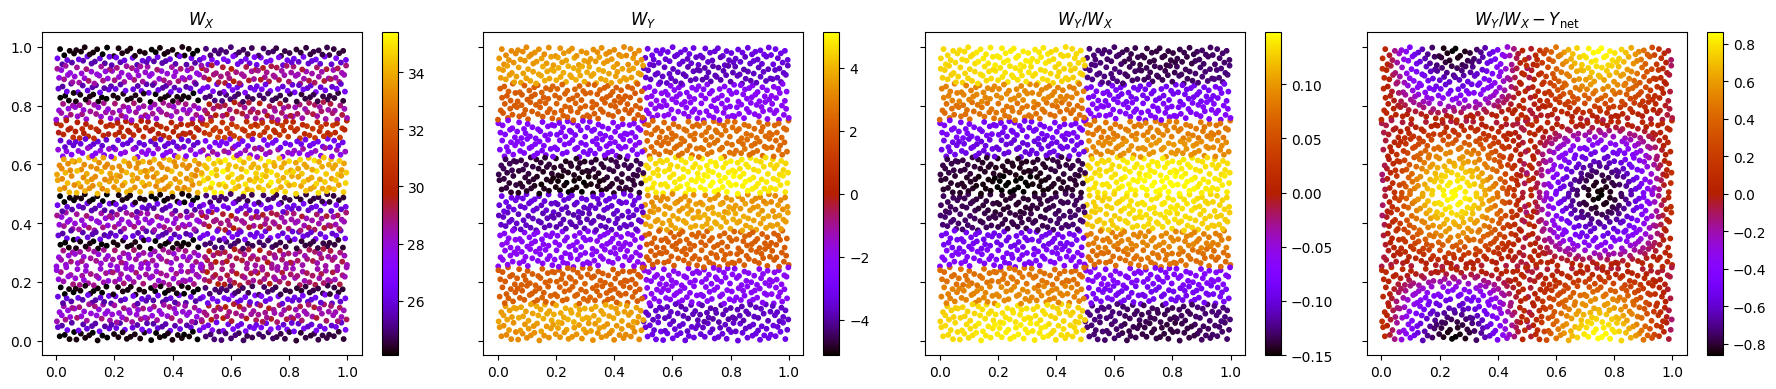

In [64]:
_s = 10
fig,ax = pyplot.subplots(nrows=1,ncols=4,figsize=(18,4),sharex=True,sharey=True)
_scatter_x = ax[0].scatter(z[:,0],z[:,1],c=Wx,cmap="gnuplot",s=_s)
fig.colorbar(_scatter_x)
ax[0].set_title(r"$W_X$")
_scatter_y = ax[1].scatter(z[:,0],z[:,1],c=Wy,cmap="gnuplot",s=_s)
fig.colorbar(_scatter_y)
ax[1].set_title(r"$W_Y$");
_scatter_rat = ax[2].scatter(z[:,0],z[:,1],c=Wy/Wx,cmap="gnuplot",s=_s)
fig.colorbar(_scatter_rat)
ax[2].set_title(r"$W_Y/W_X$");
_scatter_rat_diff = ax[3].scatter(z[:,0],z[:,1],c=Wy/Wx-y_net,cmap="gnuplot",s=_s)
fig.colorbar(_scatter_rat_diff)
ax[3].set_title(r"$W_Y/W_X-Y_\mathrm{net}$")
fig.tight_layout()

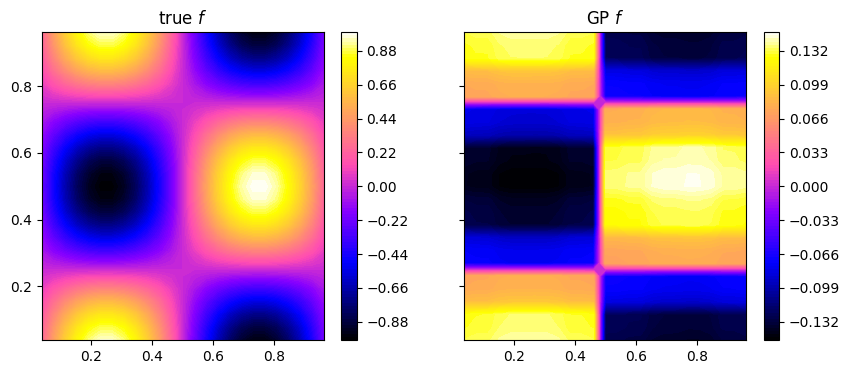

In [52]:
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(10,4),sharex=True,sharey=True)
ax[0].set_title(r"true $f$")
_cf_true = ax[0].contourf(x0_data_mesh,x1_data_mesh,y_data.reshape(x0_data_mesh.shape),cmap="gnuplot2",levels=100)
fig.colorbar(_cf_true)
ax[1].set_title(r"GP $f$")
_cf_hat = ax[1].contourf(x0_data_mesh,x1_data_mesh,y_hat.reshape(x0_data_mesh.shape),cmap="gnuplot2",levels=100)
fig.colorbar(_cf_hat);